# Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

__Обозначения:__ <br>
   > p - глубина истории, сколько измерений назад учитываем в моделях<br>
   > h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)<br>

In [63]:
# Подключение используемых библиотек
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor as GB

In [61]:
# Дополнительные функции
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def df_split_train_test(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def show_pjme_mw_model(df_day, h, test, y_test, y_pred, date):
    plt.figure( figsize=( 20, 4 ))
    plt.plot(test.index[h:], y_pred, label='predict GB data', c='orange')
    plt.plot(test.index[h:], y_test, label='test data', c='blue', linestyle='--')
    plt.plot(df_day.loc[date:].index, df_day.loc[date:]['PJME_MW'], label='исходный ряд', c='grey')

    plt.xlabel('Время')
    plt.ylabel('PJME_MW')
    plt.legend(loc='best')
    plt.title(f"h - {h}")

def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

## 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [13]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [14]:
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
Time               145374 non-null object
PJME_MW            145374 non-null float64
year               145374 non-null int64
month              145374 non-null int64
dayofmonth         145374 non-null int64
quarter            145374 non-null int64
dayofyear          145374 non-null int64
weekofyear         145374 non-null int64
dayofweek          145374 non-null int64
hour               145374 non-null int64
is_holiday         145374 non-null int64
is_prev_holiday    145374 non-null int64
is_next_holiday    145374 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 19.0+ MB


In [18]:
df_day = df.resample('D').mean()
data_exp_1 = exponential_smoothing(df_day['PJME_MW']  , 0.05)

Text(0.5, 1.0, 'PJME_MW')

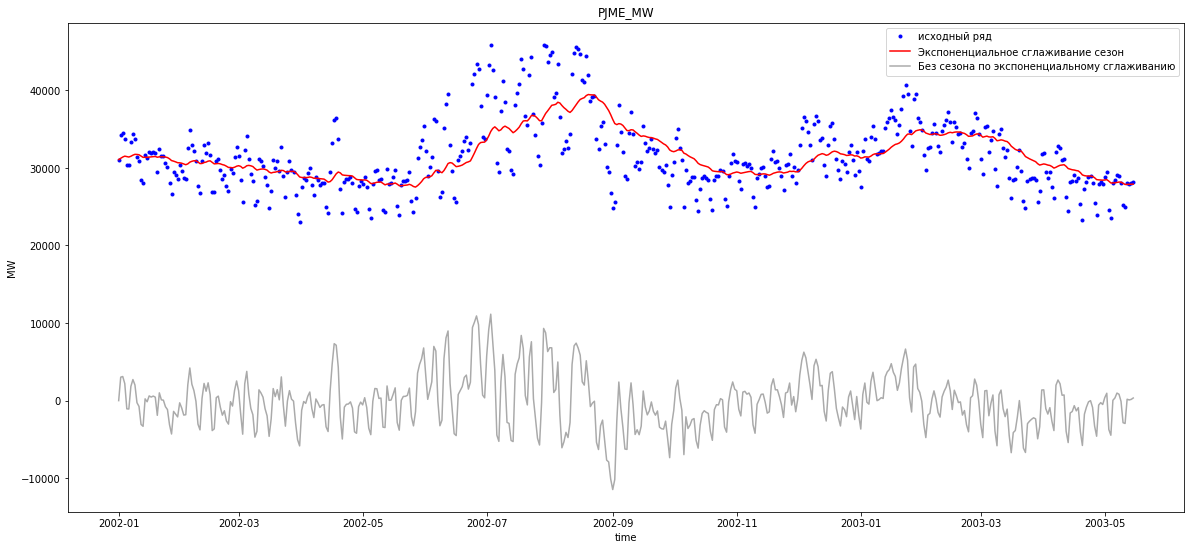

In [31]:
plt.figure(figsize=(20, 9))
plt.plot(df_day.index[:500], df_day['PJME_MW'].values[:500], '.b', label='исходный ряд')
plt.plot(df_day.index[:500],data_exp_1[:500] , color = 'red', label="Экспоненциальное сглаживание сезон")
plt.plot(df_day.index[:500], df_day['PJME_MW'].values[:500] - data_exp_1[:500] , color = '1110', label="Без сезона по экспоненциальному сглаживанию")
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [39]:
df2 = pd.DataFrame(data_exp_1, index=df_day.index)
df2.head()

,0
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


In [40]:
# Добавили историю на глубину 3 измерения от текущего (р=3)
df2['t'] = 0
df2.iloc[1:,1] = df2.iloc[:-1,0].values
df2['t1'] = 0
df2.iloc[2:,2] = df2.iloc[:-2,0].values
df2['t2'] = 0
df2.iloc[3:,3] = df2.iloc[:-3,0].values
df2.fillna(0)

,0,t,t1,t2
Date,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257
...,...,...,...,...
2018-07-30,35241.910443,35362.146957,35530.527499,35584.989473
2018-07-31,35206.769087,35241.910443,35362.146957,35530.527499
2018-08-01,35407.970216,35206.769087,35241.910443,35362.146957


In [41]:
# добавили сглаживание (3 вида - просто для коллекции)
df2['exp_0_01'] = exponential_smoothing(df2[0], 0.01)
df2['exp_0_03'] = exponential_smoothing(df2[0], 0.03)
df2['exp_0_08'] = exponential_smoothing(df2[0], 0.08)

In [42]:
# добавим разности - 1-й порядок
df2['diff1'] = 0
df2['diff1'].iloc[1:] = df2.iloc[:-1,0] - df2.iloc[1:,0]

In [43]:
df2.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,0.0


In [52]:
splite_date = '18-04-2010'

train, test = df_split_train_test(df2, splite_date)

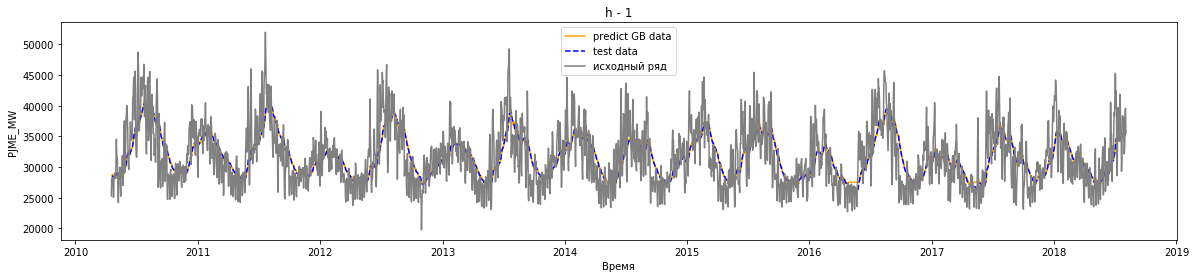

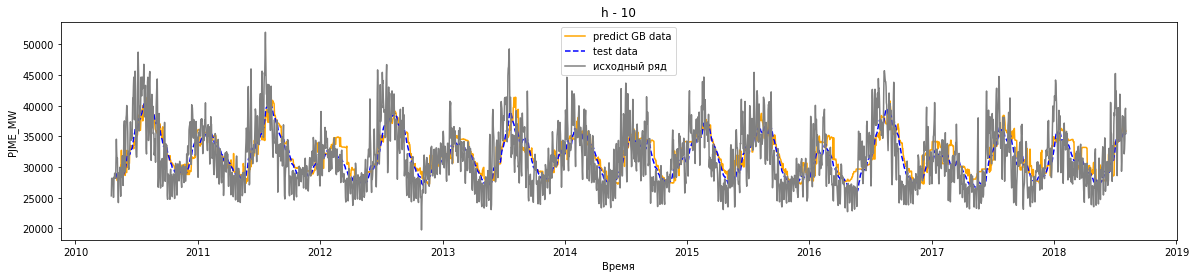

In [56]:
h_dict = {
    1: {'test': None, 'pred': None},
    10: {'test': None, 'pred': None}
}

for h in h_dict:
    X_train = train.iloc[:-h,:]
    y_train = train[train.columns[0]].values[h:]
    X_test = test.iloc[:-h,:]
    y_test = test[test.columns[0]].values[h:]

    gb_model = GB(max_depth=15, random_state=21, n_estimators=100)
    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)

    h_dict[h]['test'] = y_test
    h_dict[h]['pred'] = y_pred

    show_pjme_mw_model(df_day, h, test, y_test, y_pred, splite_date)

## 2. Оцените ошибки моделей из п.1

In [62]:
for h in h_dict:
    gb_err = mean_absolute_percentage_error(h_dict[h]['test'], h_dict[h]['pred'])
    print(f"Прогноз h - {h}, ошибка: {gb_err}")

Прогноз h - 1, ошибка: 0.5437141663906048
Прогноз h - 10, ошибка: 3.4095522847497666


## 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

При увеличении глбины, ошибка ожидаемо растет.<br>
Так при глубине h = 1, ошибка ~= 0,54%, а при глубине h = 10, ошибка ~= 3.41%.

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):<br>
* Изменение температуры за окном<br>
    __Относится к сезонному ряду, хотя есть предположение, что еще можно отнести к тренду__
* Количество денег, которые тратят покупатели в интернет магазине<br>
    __Зависит от времени и типа предмета покупки, это можно отнести как к сезонному ряду, так и к тренду, хотя если не брать во внимание популярные и сеззонные товары, то скорее стационарный.__
* Вес растущего котенка<br>
    __Сомневаюсь, что стационарный, скорее ряд с трендом__
* Прирост объема деревьев в лесу от времени<br>
    __Это будет стационарный ряд, только если будет соблюдаться популяция деревьев__